In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import glob
import pandas as pd
import os
from scipy import signal
import DasPrep as dp


# import pyproj


from nptdms import TdmsFile
import DasPrep as idas

# datapath = 'G:\\xfj_das\\'

workpath = '/home/wuzm/data/DAS_DL_Dataset/data/xfj/das_event_reorganize/'
savefigpath = '/home/wuzm/data/DAS_DL_Dataset/data/xfj/das_event_reorganize_fig/'
# savefigpath_refine = 'D:\\sustech_dir\\workdir\\das-event_reorganize_fig_2\\'
resave_npy_path = '/home/wuzm/data/DAS_DL_Dataset/DASEventData/data/'

save_csv_path = '/home/wuzm/data/DAS_DL_Dataset/DASEventData/phase_picks/'
eq_catalog_file = '/home/wuzm/data/DAS_DL_Dataset/data/xfj/DetectedFinal.dat'

# datapath = '/home/disk/disk02/bluo/xfj_das/'
# das_file = glob.glob(datapath+'*.tdms')
# das_file.sort()

# dp.read_das(das_file[0], metadata='True')

In [2]:
eq_cat = pd.read_csv(eq_catalog_file, delim_whitespace=True)


eq_time = np.array([datetime.datetime.strptime(str(eq_cat['Date'].values[i])+' '+str(eq_cat['Time'].values[i]), '%Y/%m/%d %H:%M:%S.%f') 
       for i in range(len(eq_cat))])

# eq_time = eq_time - datetime.timedelta(seconds=8*3600)   # this catalog was in UTC

lat = eq_cat['Lat.'].values
lon = eq_cat['Lon.'].values
mag = eq_cat['Mag.'].values
dep = eq_cat['Dep.'].values
Coef = eq_cat['Coef.'].values

ev_files = glob.glob(workpath+'*.npy')
get_number_in_file =  lambda x: int(os.path.basename(x).split('_')[-1].split('.')[0])
ev_files.sort(key=get_number_in_file)
print(np.mean(mag))

eq_cat[mag >-2]
 # strong mag


-0.7189805825242719


#No.        Date          Time    Lat.     Lon.  Dep.  Mag.   Coef.  \
0       1  2022/04/18  08:33:01.642  23.902  114.455   8.2 -1.06  0.3041   
1       2  2022/04/18  09:09:23.602  23.919  114.474   8.2  0.20  1.0000   
2       6  2022/04/18  10:05:11.643  23.920  114.475   8.2 -1.13  0.3917   
3       7  2022/04/18  14:02:33.204  23.839  114.502   8.0 -0.92  0.3254   
4       8  2022/04/18  15:41:51.984  23.839  114.481   8.0 -1.12  0.5346   
..    ...         ...           ...     ...      ...   ...   ...     ...   
407    10  2022/05/21  21:10:48.125  23.755  114.546   6.3  0.20  1.0000   
408    49  2022/05/21  21:41:37.946  23.865  114.519   7.6 -1.00  0.3111   
409     2  2022/05/22  10:32:41.023  23.857  114.507   7.6 -0.84  0.4218   
410     3  2022/05/22  16:17:23.484  23.857  114.507   7.6 -0.94  0.4239   
411     4  2022/05/22  18:12:09.285  23.837  114.515   8.1  0.50  0.8919   

     N(*MAD)     Reference  
0    23.8351  2.022042e+13  
1    77.5266  2.022042e+13  
2    30.4258  2.022042e+13  
3    21.4109  2.022042e+13  
4    22.4324  2.022043e+13  
..       ...           ...  
407  27.2660  2.022052e+13  
408  21.8679  2.022042e+13  
409  26.9108  2.022042e+13  
410  27.0473  2.022042e+13  
411  29.9312  2.022052e+13  

[395 rows x 10 columns]

# 读取npy对地震波进行震相识别是确定震源位置和进行体波走时层析成像的重要前提， 因此，准确的震相识别方法具有重要的研究意义。地震目录的质量主要取决于到 达时间测量的数量和准确性。

/home/wuzm/data/DAS_DL_Dataset/data/xfj/das_event_reorganize/xfj_das_re_eq_151.npy
(2944, 24000)
(2944, 8000)


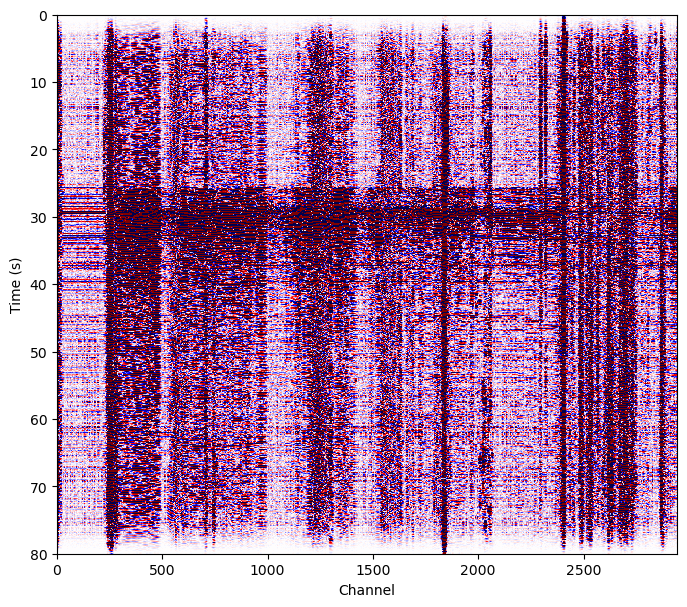

In [5]:
%matplotlib inline
import matplotlib.animation as animation
import das_event_manual_pick as das_mp
from scipy import signal
import DasPrep as dp
from datetime import datetime, timedelta


dt_before, dt_after = 20, 60

save_file_name_prefix = workpath + 'xfj_das_re_eq_'



iev = 151
# if len(list(click_pos.keys()))>0:
#     iev = max(list(click_pos.keys())) + 1
# else:
#     iev = 21

savename = save_file_name_prefix + str(iev) + '.npy'

fq = 300
dt = 1./300.
print(savename)
data_raw = np.load(savename)
print(data_raw.shape)

# down sample and save raw data 
data_raw_d = signal.decimate(data_raw, 3, axis=-1).astype('float32')
dt *= 3
fq = 100 
resave_name = resave_npy_path + 'xfj_das_100Hz_' + str(iev) + '.npy'
np.save(resave_name, data_raw_d.astype('float32'))

# data process
data_p = dp.das_preprocess(data_raw_d)
# f1, f2 = 15, 35
f1, f2 = 1,  20
data = dp.bandpass(data_p * signal.windows.tukey(data_p.shape[1], alpha=0.2), dt, fl=f1, fh=f2)
# data = dp.lowpass(data_p * signal.windows.tukey(data_p.shape[1], alpha=0.2), dt,  fh=10)
# data = data_p
print(data.shape)

# plot hot map to find the arrive time
# https://stackoverflow.com/questions/39079562/matplotlib-animation-vertical-cursor-line-through-subplots
fig, ax = plt.subplots(figsize=[8,7])

clim = data.std() *0.01


ax.imshow(data[:, :].T, aspect='auto', cmap ='seismic', 
           vmin = -clim, vmax = clim,
          extent=[0,data.shape[0], data.shape[1]*dt, 0])

# ax.set_ylim([5, 1])

ax.set_xlabel('Channel')
ax.set_ylabel('Time (s)')

plt.show()

# das2sac

In [3]:
from obspy import Stream, Trace
import numpy as np

def das_st_write_sac(das_tr, date_folder_path, write_coordinates=False):
    chn = int(das_tr.stats.location)
    if chn%3 == 0:
        das_tr.stats.channel = 'HHE'
    elif chn%3 == 1:
        das_tr.stats.channel = 'HHN'
    elif chn%3 == 2:
        das_tr.stats.channel = 'HHZ'
    if write_coordinates:
        das_tr.stats.sac = {'stla': das_tr.stats.coordinates['latitude'], 
                      'stlo': das_tr.stats.coordinates['longitude']}
    nw = das_tr.stats.network
    sta = das_tr.stats.station
    
    das_tr.write(date_folder_path + '//'+'xfj_das_re_eq_' + str(iev)+'.'+nw+'.'+sta+'.'+str(chn//3*3)+'.'+das_tr.stats.channel+'.sac', format='SAC') 

save_file_name_prefix = workpath + 'xfj_das_re_eq_'
das_file = glob.glob(save_file_name_prefix+'*.npy')
for iev in range(66 , 408):
    savename = save_file_name_prefix + str(iev) + '.npy'
    if savename in das_file:
        fq = 300
        dt = 1./300.
        print(savename)
        data_raw = np.load(savename)
        # down sample and save raw data 
        data_raw_d = signal.decimate(data_raw, 3, axis=-1).astype('float32')
        dt *= 3
        fq = 100 
        resave_name = resave_npy_path + 'xfj_das_100Hz_' + str(iev) + '.npy'
        np.save(resave_name, data_raw_d.astype('float32'))



        ch1 = 0
        ch2 = 2944
        das_ch_id = np.arange(ch1, ch2)

        nw = 'xfj'
        sta = 'DAS'
        start_time = eq_time[iev]

        for ich in das_ch_id:
            data_ich = np.where(das_ch_id==ich)[0][0]

            tr = Trace(data=data_raw_d[ich,:], header={'network':nw, 
                                                'station': sta, 
                                                'location':str(data_ich), 
                                                'channel': str(ich),
                                                'starttime':str(start_time), 
                                                'delta':dt})
            
            das_st_write_sac(tr , "/home/disk/disk01/wzm/DAS_DL_Dataset/DASEventData/xfj_sac_data")

            

/home/wuzm/data/DAS_DL_Dataset/data/xfj/das_event_reorganize/xfj_das_re_eq_66.npy
/home/wuzm/data/DAS_DL_Dataset/data/xfj/das_event_reorganize/xfj_das_re_eq_67.npy
/home/wuzm/data/DAS_DL_Dataset/data/xfj/das_event_reorganize/xfj_das_re_eq_68.npy
/home/wuzm/data/DAS_DL_Dataset/data/xfj/das_event_reorganize/xfj_das_re_eq_69.npy
/home/wuzm/data/DAS_DL_Dataset/data/xfj/das_event_reorganize/xfj_das_re_eq_70.npy
/home/wuzm/data/DAS_DL_Dataset/data/xfj/das_event_reorganize/xfj_das_re_eq_71.npy
/home/wuzm/data/DAS_DL_Dataset/data/xfj/das_event_reorganize/xfj_das_re_eq_72.npy
/home/wuzm/data/DAS_DL_Dataset/data/xfj/das_event_reorganize/xfj_das_re_eq_73.npy
/home/wuzm/data/DAS_DL_Dataset/data/xfj/das_event_reorganize/xfj_das_re_eq_74.npy
/home/wuzm/data/DAS_DL_Dataset/data/xfj/das_event_reorganize/xfj_das_re_eq_75.npy
/home/wuzm/data/DAS_DL_Dataset/data/xfj/das_event_reorganize/xfj_das_re_eq_76.npy
/home/wuzm/data/DAS_DL_Dataset/data/xfj/das_event_reorganize/xfj_das_re_eq_77.npy
/home/wuzm/data/

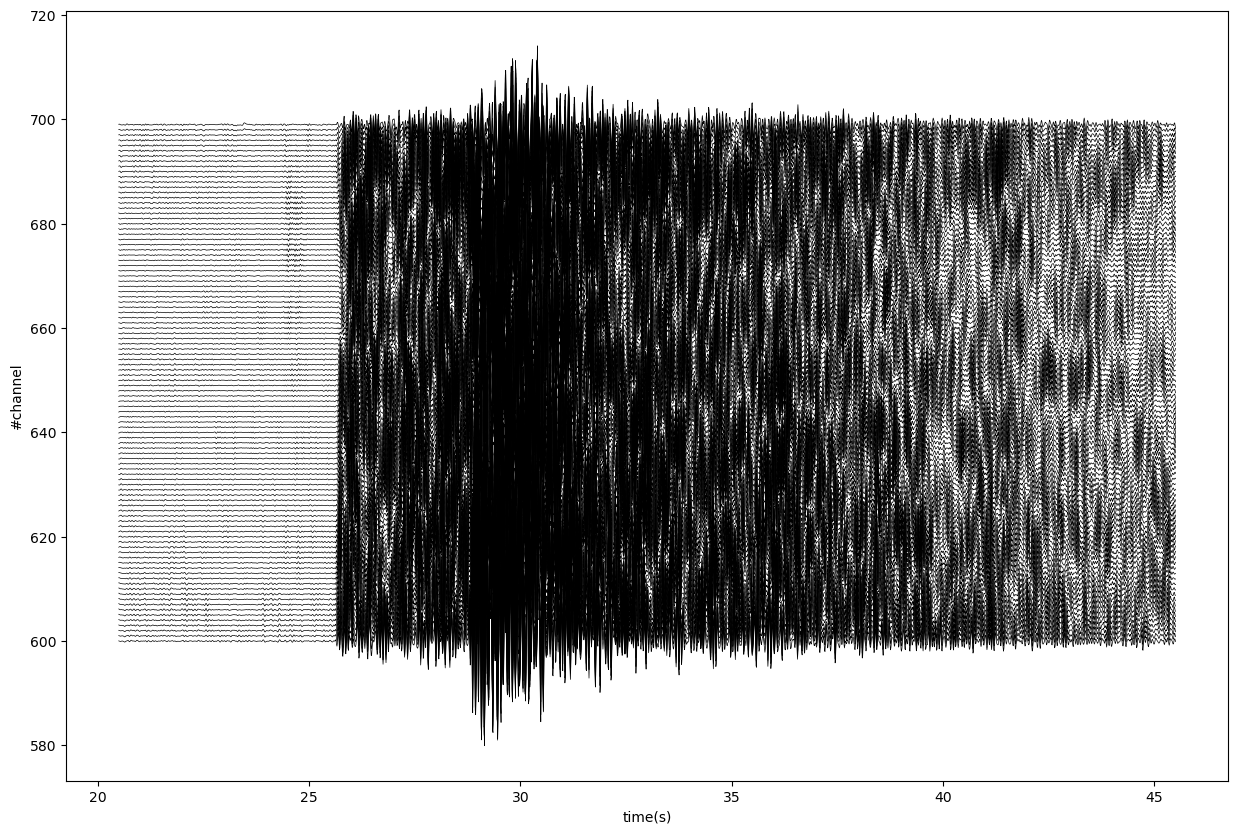

In [ ]:
%matplotlib inline

import matplotlib.animation as animation
from scipy import signal
click_pos = {}
line_x , line_y = list() , list() #time and channel

def onMouseMove(event, axx):
    axx.lines = [] #axx.lines[:1]
    axx.axhline(y=event.ydata, color="k" , linewidth=3)
    axx.axvline(x=event.xdata, color="k" , linewidth=3)
    ax.figure.canvas.draw()

def onMouseClick(event, axx):
    print(event.xdata, event.ydata)
    click_pos[int(event.ydata)] = event.xdata 
    axx.scatter(x=event.xdata, y=event.ydata ,  s=2 )
    
    line_x.append(event.xdata)
    line_y.append(event.ydata)

    axx.plot(line_x , line_y ,linewidth=1)
    axx.figure.canvas.draw()

    

class Click():
    def __init__(self, ax, func, button=1):
        self.ax=ax
        self.func=func
        self.button=button
        self.press=False 
        self.move = False
        self.c1=self.ax.figure.canvas.mpl_connect('button_press_event', self.onpress)
        self.c2=self.ax.figure.canvas.mpl_connect('button_release_event', self.onrelease)
        self.c3=self.ax.figure.canvas.mpl_connect('motion_notify_event', self.onmove)

    def onclick(self,event):
        if event.inaxes == self.ax:
            if event.button == self.button:
                self.func(event, self.ax)
    def onpress(self,event):
        self.press=True
    def onmove(self,event):
        if self.press:
            self.move=True
    def onrelease(self,event):
        if self.press and not self.move:
            self.onclick(event)
        self.press=False; self.move=False
        
        
class MouseMove:
    def __init__(self, ax, func):
        self.ax=ax
        self.func = func
        self.c1=self.ax.figure.canvas.mpl_connect('motion_notify_event', self.onMouseMove)
    def onMouseMove(self,event):
        if event.inaxes == self.ax:
            self.func(event, self.ax)

####
das_ch1 , das_ch2 = 600 , 700

t1 , t2 = 20.5,45.5
data2 = data[: , int(fq * t1) : int(fq * t2) ]

# data2 = np.cumsum(data2, axis=1) #计算应变率

def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w

def smooth2(a, nx, ny):
    kernel = np.ones((nx,ny)) * 1 / (nx * ny)
    r = signal.convolve2d(a, kernel, mode = 'same')
    return r

data2 = smooth2( data2 , 10 , 1  ) #滑动平均

fig, ax = plt.subplots( figsize=(15,10))

clim = data2.std() 

# ax.imshow(data2[:, :], aspect='auto', cmap ='seismic', 
#            vmin = -clim, vmax = clim,
#           extent=[0,data2.shape[1]*dt, data.shape[0], 0])
# ax.set_ylim(-100, 3200)

for i in range(das_ch1 , das_ch2 , 1 ):
    ax.plot(np.linspace(t1 ,  t2  , data2.shape[1] )   , data2[i]/100 + i, 'k', linewidth=0.5)

ax.set_ylabel("#channel")
ax.set_xlabel("time(s)")
    
click = Click(ax, onMouseClick, button=1)
mm    = MouseMove(ax, onMouseMove)

plt.show()


In [68]:
# 选更清晰的震级 
# 精细打点 通道间隔1 100道需要15-20分钟
#粗略打点 通道间隔1  100道需要3分钟  结果对比 
#通道间隔大约为3 的效果更好
# 整理流程时间
print(line_y)

[1682.6867674908888, 2390.183372936469, 1414.6956290645326, 1007.3490986564714, 848.6983447080686, 692.1915198670765, 574.27541895948, 488.51825466304604]


In [70]:
from scipy import interpolate
import csv
from datetime import datetime, timedelta

# 定义需要插值的点
das_ch1 = int(line_y[-1]+1)
das_ch2 = int(line_y[0])
ch_list = np.arange(das_ch1 , das_ch2 , dtype=np.int16)
# 进行线性插值
f1=interpolate.interp1d(line_y , line_x , kind='linear')
time_list =f1(ch_list)


# # t1 , t2 = 26.5,29.5
# data2 = data[: , int(fq * t1) : int(fq * (t2+2)) ]
# fig, ax = plt.subplots( figsize=(8, 10))
# for i in range(das_ch1 , das_ch2 ):
#     ax.plot( np.linspace(0 ,  data2.shape[1]*dt  , data2.shape[1] ) , data2[i]/200 + i, 'k', linewidth=0.5)
# ax.plot(time_list , ch_list , linewidth=1)


#写入csv
csv_file_path = save_csv_path + 'xfj_das_100Hz_' + str(iev) + '.csv'

with open(csv_file_path,"w") as csvfile: 
    writer = csv.writer(csvfile)
    #先写入columns_name
    # writer.writerow(["channel_index","phase_index","phase_time","phase_score","phase_type"])
    #dtype: int32,int32,str,float32,str
    # e.g.:1000,3000,2019-07-04T17:33:520000+00:00,0.98,P
    #写入多行用writerows
    
    # arglist = ['Date', 'Time', 'Lat.', 'Lon.', 'Mag.', 'Dep.']

# eq_cat.iloc[ieq][arglist]
    for i in range(das_ch1 , das_ch2):
        channel_index =  i 
        phase_index = (int(f1(i)) + t1) * fq 
        t = datetime.strptime(eq_cat.iloc[iev]['Date'] +"_"+ eq_cat.iloc[iev]['Time'], '%Y/%m/%d_%H:%M:%S.%f')
        phase_time = t + timedelta(seconds=f1(i) + t1 - 20) 
        phase_score = eq_cat.iloc[iev]['Mag.']
        phase_type = "P"
        writer.writerow([channel_index , phase_index ,phase_time , phase_score , phase_type ])

print(int(f1(i)) + t1,"save")


29.5 save


# STFT

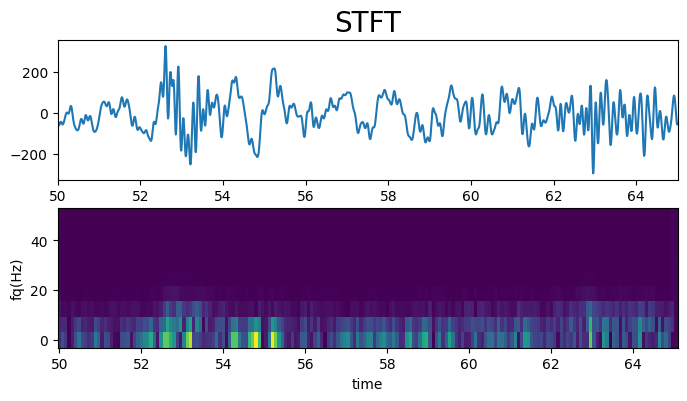

In [12]:
%matplotlib inline

import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
 
 
 
fq=100 #采样频率
# t1 , t2 = 30,45

# data_ = data_raw_d[: , int(fq * t1) : int(fq * t2) ]
data_tf=data2[3000]  #一维数据
t = np.linspace(t1, t2 , num= int(t2-t1) * fq)


f, t_, nd = signal.stft(data_tf,fs=fq,window='hann',nperseg=16,noverlap=None,nfft=None,
                       detrend=False,return_onesided=True,boundary='zeros',padded=True,axis=-1)
#  fs:时间序列的采样频率,  nperseg:每个段的长度，默认为256(2^n)   noverlap:段之间重叠的点数。如果没有则noverlap=nperseg/2
 
#window ： 字符串或元祖或数组，可选需要使用的窗。
# #如果window是一个字符串或元组，则传递给它window是数组类型，直接以其为窗，其长度必须是nperseg。
# 常用的窗函数有boxcar，triang，hamming， hann等，默认为Hann窗。
 
#nfft ： int，可选。如果需要零填充FFT，则为使用FFT的长度。如果为 None，则FFT长度为nperseg。默认为无
 
# detrend ： str或function或False，可选
# 指定如何去除每个段的趋势。如果类型参数传递给False，则不进行去除趋势。默认为False。
 
# return_onesided ： bool，可选
# 如果为True，则返回实际数据的单侧频谱。如果 False返回双侧频谱。默认为 True。请注意，对于复杂数据，始终返回双侧频谱。
 
# boundary ： str或None，可选
# 指定输入信号是否在两端扩展，以及如何生成新值，以使第一个窗口段在第一个输入点上居中。
# 这具有当所采用的窗函数从零开始时能够重建第一输入点的益处。
# 有效选项是['even', 'odd', 'constant', 'zeros', None].
# 默认为‘zeros’,对于补零操作[1, 2, 3, 4]变成[0, 1, 2, 3, 4, 0] 当nperseg=3.
 
# 填充： bool，可选
# 指定输入信号在末尾是否填充零以使信号精确地拟合为整数个窗口段，以便所有信号都包含在输出中。默认为True。
# 填充发生在边界扩展之后，如果边界不是None，则填充为True，默认情况下也是如此。
 
# axis ： int，可选
# 计算STFT的轴; 默认值超过最后一个轴(即axis=-1)。
plt.figure(figsize=(8, 4))
plt.subplot(211)

plt.plot(t, data_tf)
plt.xlabel("t(s)")
plt.xlim(t1,t2)
plt.title('STFT',  fontsize=20)
plt.subplot(212)

plt.pcolormesh(t_+t1, f, np.abs(nd))
# plt.contourf(t_, f,  np.abs(nd),vmax = 200 ,vmin = 0)

# plt.title('STFT')
plt.ylabel('fq(Hz)')
plt.xlabel('time')
# plt.colorbar()
plt.show()

# Continuous Wavelet Transform,CWT

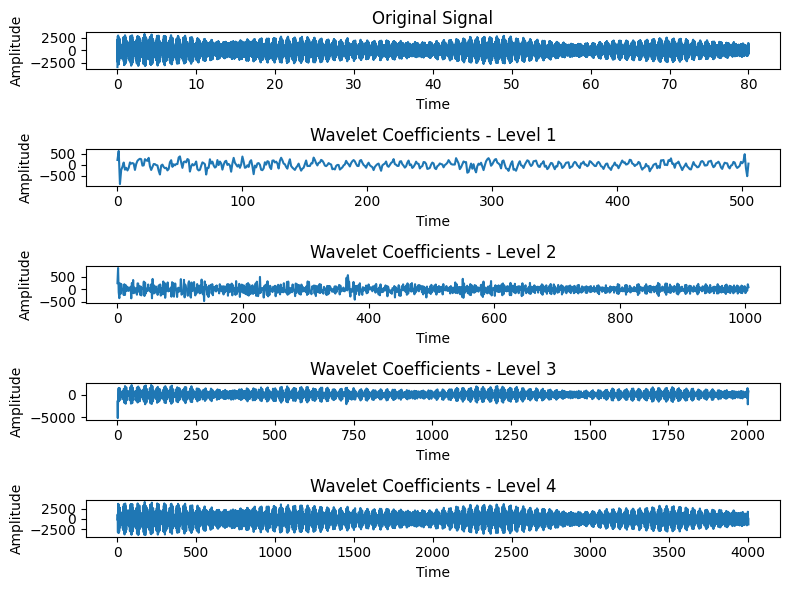

In [17]:
#使用python实现小波变换

import numpy as np
import pywt
import matplotlib.pyplot as plt

# 生成信号变量
t = np.linspace(0, 80, num=8000)
# signal = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 20 * t) + np.sin(3 * np.pi * 30 * t)
#
# 添加随机噪声
# noise = np.random.normal(0, 0.05, len(signal))
signal = data_raw_d[0]

# 常见的几种小波基函数包括： 
 
# 1. Daubechies小波基（db）：Daubechies小波基是最常用的小波基函数之一。它具有紧凑支持和良好的频率局部化特性。常见的Daubechies小波基包括db2、db4、db6等。 
 
# 2. Symlets小波基（sym）：Symlets小波基是对称的Daubechies小波基。它们在频率局部化和相位对称性方面与Daubechies小波基类似。常见的Symlets小波基包括sym2、sym4、sym8等。 
 
# 3. Coiflets小波基（coif）：Coiflets小波基是具有紧凑支持和较好频率局部化特性的小波基。它们在一些应用中比Daubechies小波基具有更好的性能。常见的Coiflets小波基包括coif1、coif2、coif3等。 
 
# 4. Biorthogonal小波基（bior）：Biorthogonal小波基是一组成对的小波基函数。它们具有可变的支持长度和频率响应。常见的Biorthogonal小波基包括bior2.2、bior3.3、bior6.8等。 

wavelet_name = 'db4'  # 定义小波基名称为'db4'
#wavelet_name = 'sym4'  # 定义小波基名称为'sym4'
#wavelet_name = 'bior3.3'  # 定义小波基名称为'bior3.3'

# 小波变换
coeffs = pywt.wavedec(signal, wavelet_name, level=4)  # 使用指定小波基进行4级小波分解

# 绘制原始信号图像
plt.figure(figsize=(8, 6))
plt.subplot(5, 1, 1)
plt.plot(t, signal)
plt.title('Original Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# 绘制小波分解信号图像
for i in range(1, len(coeffs)):
    plt.subplot(5, 1, i+1)
    plt.plot(coeffs[i])
    plt.title(f'Wavelet Coefficients - Level {i}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

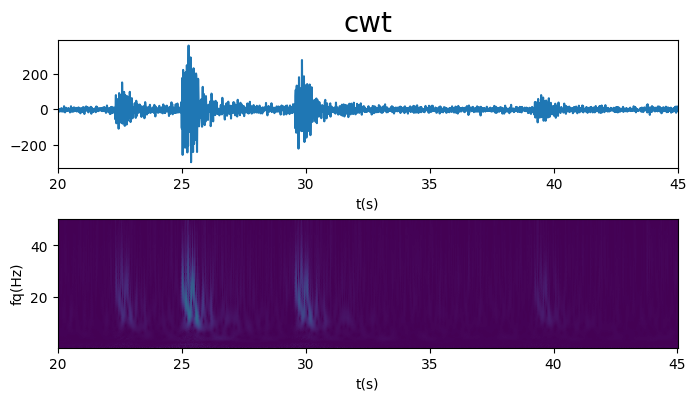

In [52]:

import pywt
import matplotlib.pyplot as plt
import numpy as np


# 小波
# sampling_rate = 1024
# t = np.arange(0, 1.0, 1.0 / sampling_rate)
# f1 = 100
# f2 = 200
# f3 = 300
# f4 = 400
# data = np.piecewise(t, [t < 1, t < 0.8, t < 0.5, t < 0.3],
#                     [lambda t: 400*np.sin(2 * np.pi * f4 * t),
#                      lambda t: 300*np.sin(2 * np.pi * f3 * t),
#                      lambda t: 200*np.sin(2 * np.pi * f2 * t),
#                      lambda t: 100*np.sin(2 * np.pi * f1 * t)])


 
# sampling_rate=100 #采样频率
# data=data_raw_d[800]  #一维数据
# # t = np.arange(0, 1.0, 1.0 / sampling_rate)
# t = np.linspace(0, 80, num=8000)
 
# fs=100 #采样频率
# t1 , t2 = 20,40
# data2 = data_raw_d[: , int(fq * t1) : int(fq * t2) ]
# data_tf=data2[800]  #一维数据
# t = np.linspace(0, t2-t1 , num=(t2-t1) * fq)

fs = fq
wavename = 'cgau8'
totalscal = 256
fc = pywt.central_frequency(wavename)
cparam = 2 * fc * totalscal
scales = cparam / np.arange(totalscal, 1, -1)
[cwtmatr, frequencies] = pywt.cwt(data_tf, scales, wavename, 1.0 / fs)
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.plot(t, data_tf)
plt.xlim(t1,t2)
plt.xlabel("t(s)")
plt.title('cwt',  fontsize=20)
plt.subplot(212)
# plt.contourf(t, frequencies, abs(cwtmatr))
plt.pcolormesh(t, frequencies, abs(cwtmatr) ,vmax = 1000 )
# plt.colorbar()
plt.ylabel(u"fq(Hz)")
plt.xlabel(u"t(s)")
plt.subplots_adjust(hspace=0.4)
plt.show()

# stationary wt

[array([-1.4121267 , -7.21715971, -9.57117631, ...,  6.80318349,
        5.77019936,  0.89336259]), array([  3.36639081,   4.17464105,  -0.53116853, ..., -26.82994596,
       -14.46730778,  -2.44776577]), array([-218.41633233, -248.26327865, -196.63925224, ...,  154.46306639,
         37.77353224, -106.46101231]), array([ -0.24472854, -72.63951873, -85.9016569 , ..., 101.72894287,
        90.12609214,  53.76907694]), array([-23.71961101,  -4.82653952,  -3.54194481, ...,  74.2942346 ,
        82.80396003, -16.60797025])]


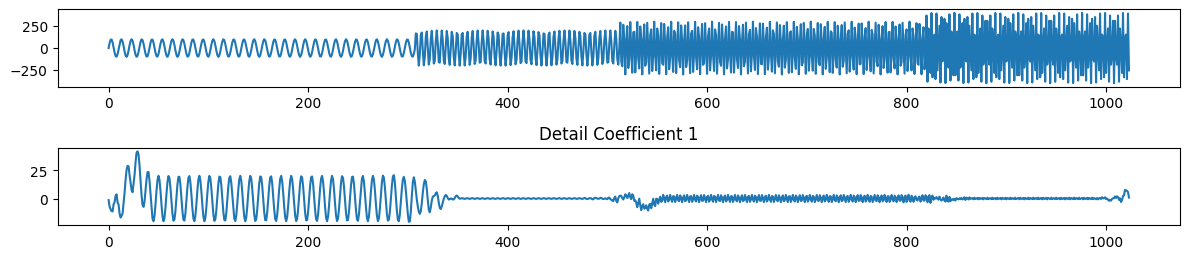

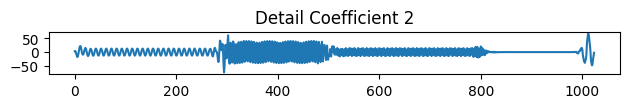

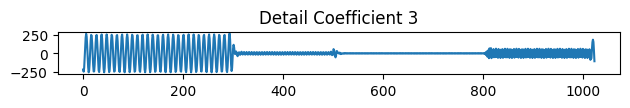

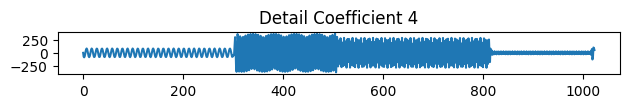

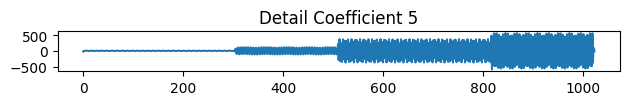

In [20]:

import pywt
import matplotlib.pyplot as plt
import numpy as np


# 小波
sampling_rate = 1024
t = np.arange(0, 1.0, 1.0 / sampling_rate)
f1 = 100
f2 = 200
f3 = 300
f4 = 400
data = np.piecewise(t, [t < 1, t < 0.8, t < 0.5, t < 0.3],
                    [lambda t: 400*np.sin(2 * np.pi * f4 * t),
                     lambda t: 300*np.sin(2 * np.pi * f3 * t),
                     lambda t: 200*np.sin(2 * np.pi * f2 * t),
                     lambda t: 100*np.sin(2 * np.pi * f1 * t)])



wavename = 'cgau8'
totalscal = 256
fc = pywt.central_frequency(wavename)
cparam = 2 * fc * totalscal
# scales = cparam / np.arange(totalscal, 1, -1)
coeffs = pywt.swt(data, 'db4' , level = 4 , start_level = 0 , trim_approx = True )
# plt.figure(figsize=(8, 4))
# plt.subplot(211)
# plt.plot(t, data)
# plt.xlabel("t(s)")
# plt.title('shipinpu',  fontsize=20)
# plt.subplot(212)
# plt.contourf(t, frequencies, abs(cwtmatr))
# plt.ylabel(u"prinv(Hz)")
# plt.xlabel(u"t(s)")
# plt.subplots_adjust(hspace=0.4)
# plt.show()

# 绘制原始信号与重构的信号 
plt.figure(figsize=(12, 8)) 
plt.subplot(6, 1, 1) # 创建4行1列的子图 
plt.plot(data) # 绘制原始信号 
# plt.title('Original Signal') # 可视化小波系数 
print(coeffs)
for i, (cA) in enumerate(coeffs): 
    plt.subplot(6, 1, i + 2) 
    plt.plot(cA) # 绘制细节系数 
    plt.title(f'Detail Coefficient {i+1}') 
    plt.tight_layout() # 调整子图间距
    plt.show() # 展示图形


# Synchrosqueezed Wavelet Transform, SWT

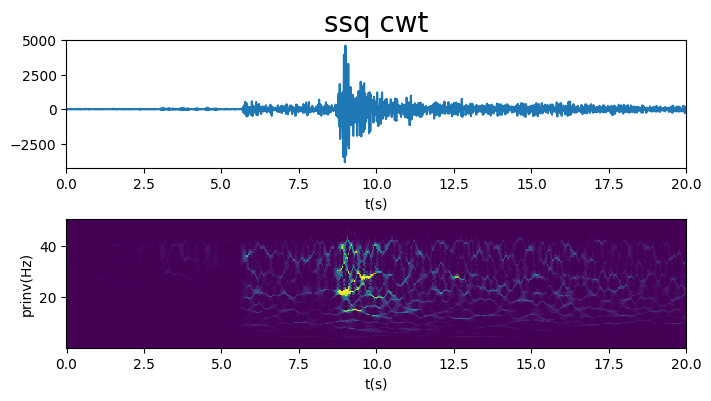

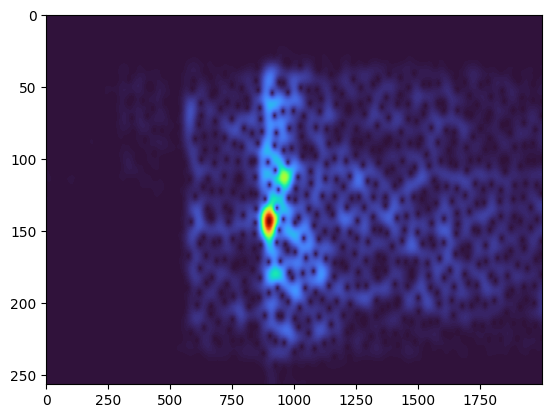

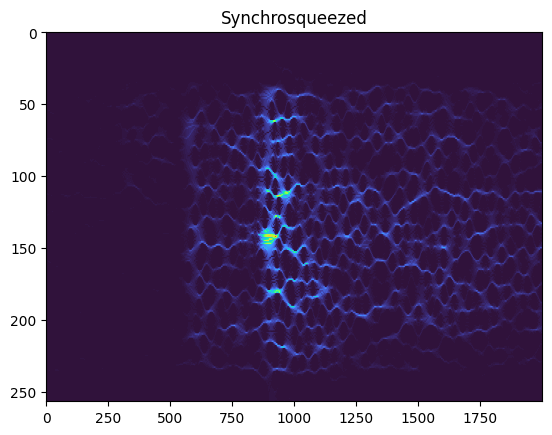

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from ssqueezepy import ssq_cwt, ssq_stft
from ssqueezepy import TestSignals, ssq_cwt, Wavelet
from ssqueezepy.visuals import imshow
def viz(x, Tx, Wx):
    plt.imshow(np.abs(Wx), aspect='auto', cmap='turbo')
    plt.show()
    
    plt.imshow(np.abs(Tx), aspect='auto', cmap='turbo')
    plt.title('Synchrosqueezed')
    plt.show()

#%%# Define signal ####################################
# N = 2048
# t = np.linspace(0, 10, N, endpoint=False)
# xo = np.cos(2 * np.pi * 2 * (np.exp(t / 2.2) - 1))
# xo += xo[::-1]  # add self reflected
# x = xo + np.sqrt(2) * np.random.randn(N)  # add noise

 
fs=100 #采样频率
t1 , t2 = 20,40
data2 = data_raw_d[: , int(fq * t1) : int(fq * t2) ]
xo=data2[800]  #一维数据
t = np.linspace(0, t2-t1 , num=(t2-t1) * fq)





# plt.plot(xo)
# plt.show()
# # plt.plot(x);  plt.show()

#%%# CWT + SSQ CWT ####################################
Twxo, Wxo, *_ = ssq_cwt(xo)
Twx, Wx, ssq_freqs_c, scales, *_ = ssq_cwt(xo,  'morlet')
# viz(xo, Twxo, Wxo)

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.plot(t, xo)
plt.xlim(0,20)
plt.xlabel("t(s)")
plt.title('ssq cwt',  fontsize=20)
plt.subplot(212)
plt.pcolormesh(t, ssq_freqs_c*100 , abs(Twx) ,vmax = 50 )

# plt.imshow(np.abs(Twxo), aspect='auto', cmap='turbo' , extent = [0,20 , 0 ,50  ])
plt.ylabel(u"prinv(Hz)")
plt.xlabel(u"t(s)")
plt.subplots_adjust(hspace=0.4)
# plt.colorbar()

plt.show()
# Twx, Wx, *_ = ssq_cwt(x)
# viz(x, Twx, Wx)
#%%
# main difference near boundaries; see `help(trigdiff)` w/ `rpadded=False`


#%%# STFT + SSQ STFT ##################################
Tsxo, Sxo, *_ = ssq_stft(xo)
viz(xo, np.flipud(Tsxo), np.flipud(Sxo))

# Tsx, Sx, *_ = ssq_stft(x)
# viz(x, np.flipud(Tsx), np.flipud(Sx))

# 离散小波变换

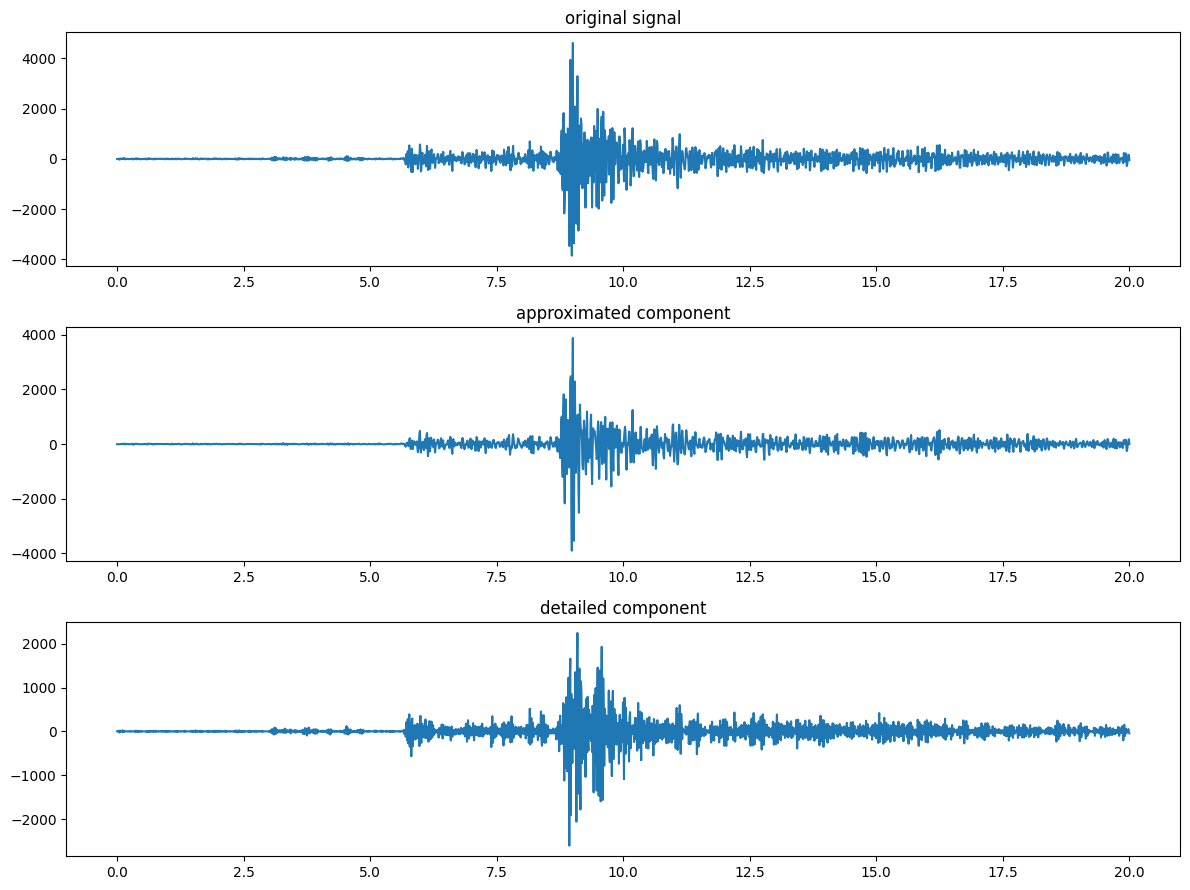

Text(0, 0.5, 'amplitude')

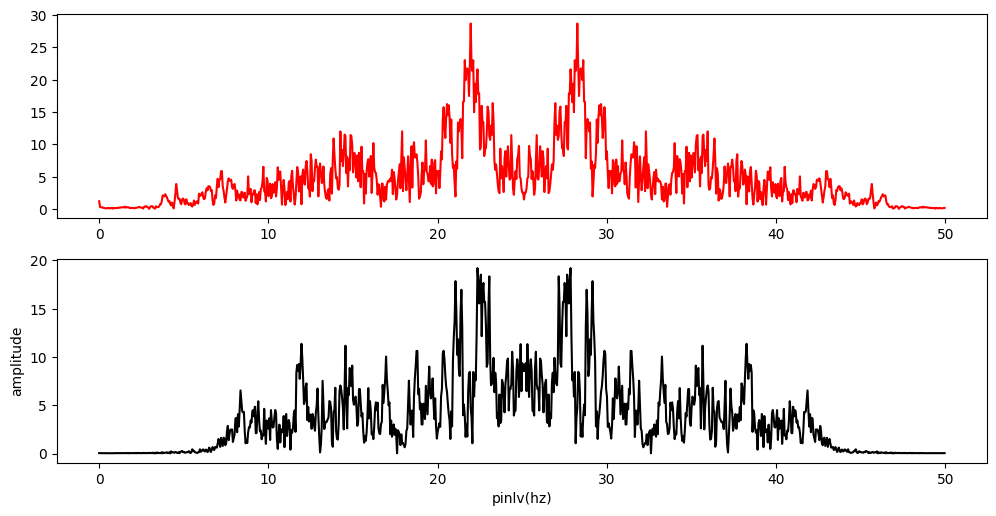

In [38]:

import pywt
import matplotlib.pyplot as plt
import numpy as np
 
# fs = 1000
# N = 200
# k = np.arange(200)
# frq = k*fs/N
# frq1 = frq[range(int(N/2))]
 
# aa = []
# for i in range(200):
#     aa.append(np.sin(0.3*np.pi*i))
# for i in range(200):
#     aa.append(np.sin(0.13*np.pi*i))
# for i in range(200):
#     aa.append(np.sin(0.05*np.pi*i))
# y = aa
N = (t2-t1) * fq

fs=100 #采样频率
t1 , t2 = 20,40
data2 = data_raw_d[: , int(fq * t1) : int(fq * t2) ]
y=data2[800]  #一维数据
x = np.linspace(0, t2-t1 , num=(t2-t1) * fq)
k = np.arange(N)
frq = k*fs/N
# frq1 = frq[range(int(N/2))]
frq1 = frq[range(int(N/2))]


    
wavename = 'db5'
cA, cD = pywt.dwt(y, wavename)
ya = pywt.idwt(cA, None, wavename, 'smooth')  # approximated component
yd = pywt.idwt(None, cD, wavename, 'smooth')  # detailed component
# x = range(len(y))
plt.figure(figsize=(12, 9))
plt.subplot(311)
plt.plot(x, y)
plt.title('original signal')
plt.subplot(312)
plt.plot(x, ya)
plt.title('approximated component')
plt.subplot(313)
plt.plot(x, yd)
plt.title('detailed component')
plt.tight_layout()
plt.show()
 
 
# 图像单边谱
plt.figure(figsize=(12, 9))
plt.subplot(311)
data_f = abs(np.fft.fft(cA))/N
data_f1 = data_f[range(int(N/2))]
plt.plot(frq1, data_f1, 'red')
 
plt.subplot(312)
data_ff = abs(np.fft.fft(cD))/N
data_f2 = data_ff[range(int(N/2))]
plt.plot(frq1, data_f2, 'k')
 
 
plt.xlabel('pinlv(hz)')
plt.ylabel('amplitude')
 



In [ ]:

# extracting_ridges.

Ridge follows indexes: [[2]
 [2]
 [2]]


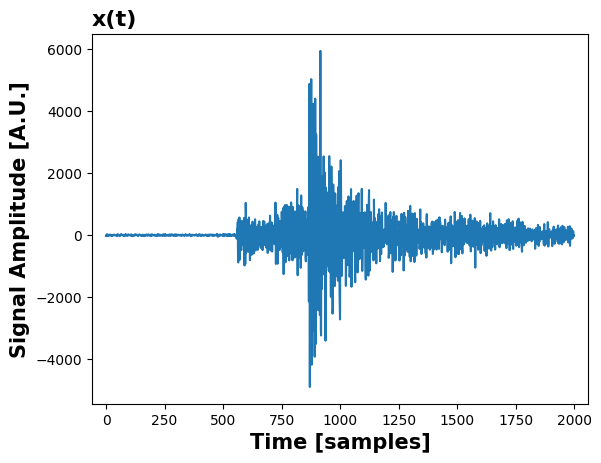

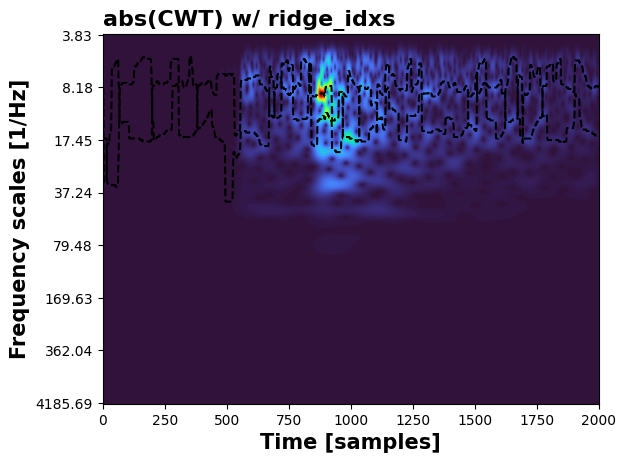

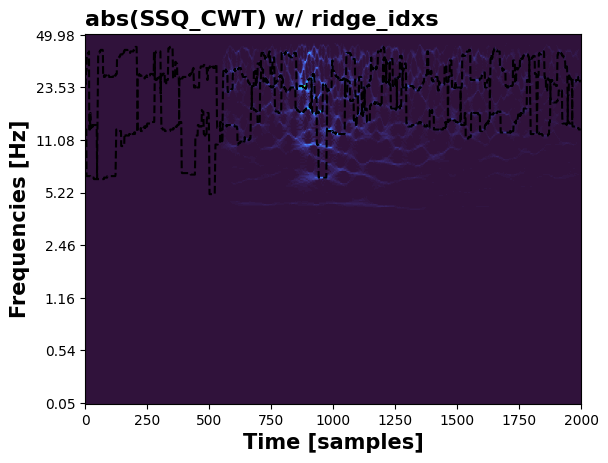

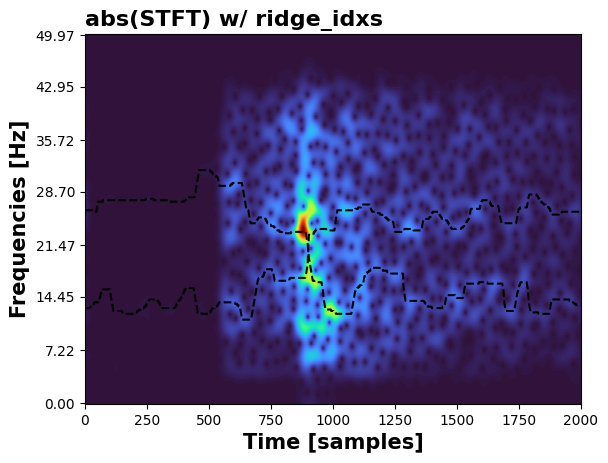

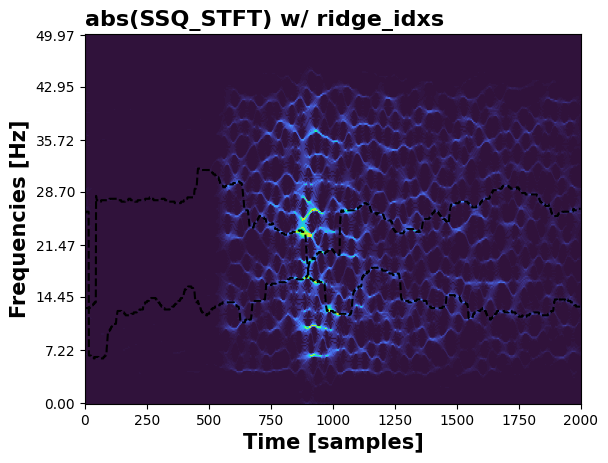

In [43]:
# -*- coding: utf-8 -*-
"""Authors: David Bondesson, OverLordGoldDragon

Ridge extraction on signals with varying time-frequency characteristics.
"""
if __name__ != '__main__':
    raise Exception("ran example file as non-main")

import numpy as np
import scipy.signal as sig
from ssqueezepy import ssq_cwt, ssq_stft, extract_ridges, TestSignals
from ssqueezepy.visuals import plot, imshow

#%%## Visual methods #########################################################
def viz(x, Tf, ridge_idxs, yticks=None, ssq=False, transform='cwt', show_x=True):
    if show_x:
        plot(x, title="x(t)", show=1,
             xlabel="Time [samples]", ylabel="Signal Amplitude [A.U.]")

    ylabel = ("Frequency scales [1/Hz]" if (transform == 'cwt' and not ssq) else
              "Frequencies [Hz]")
    title = "abs({}{}) w/ ridge_idxs".format("SSQ_" if ssq else "",
                                             transform.upper())

    ikw = dict(abs=1, cmap='turbo', yticks=yticks, title=title)
    pkw = dict(linestyle='--', color='k', xlabel="Time [samples]", ylabel=ylabel,
               xlims=(0, Tf.shape[1]))

    imshow(Tf, **ikw, show=0)
    plot(ridge_idxs, **pkw, show=1)


def tf_transforms(x, t, wavelet='morlet', window=None, padtype='wrap',
                  penalty=.5, n_ridges=2, cwt_bw=15, stft_bw=15,
                  ssq_cwt_bw=4, ssq_stft_bw=4):
    kw_cwt  = dict(t=t, padtype=padtype)
    kw_stft = dict(fs=1/(t[1] - t[0]), padtype=padtype, flipud=1)
    Twx, Wx, ssq_freqs_c, scales, *_ = ssq_cwt(x,  wavelet, **kw_cwt)
    Tsx, Sx, ssq_freqs_s, Sfs, *_    = ssq_stft(x, window,  **kw_stft)
    Sx, Sfs = Sx[::-1], Sfs[::-1]

    ckw = dict(penalty=penalty, n_ridges=n_ridges, transform='cwt')
    skw = dict(penalty=penalty, n_ridges=n_ridges, transform='stft')
    cwt_ridges      = extract_ridges(Wx,  scales,      bw=cwt_bw,      **ckw)
    ssq_cwt_ridges  = extract_ridges(Twx, ssq_freqs_c, bw=ssq_cwt_bw,  **ckw)
    stft_ridges     = extract_ridges(Sx,  Sfs,         bw=stft_bw,     **skw)
    ssq_stft_ridges = extract_ridges(Tsx, ssq_freqs_s, bw=ssq_stft_bw, **skw)

    viz(x, Wx,  cwt_ridges,      scales,      ssq=0, transform='cwt',  show_x=1)
    viz(x, Twx, ssq_cwt_ridges,  ssq_freqs_c, ssq=1, transform='cwt',  show_x=0)
    viz(x, Sx,  stft_ridges,     Sfs,         ssq=0, transform='stft', show_x=0)
    viz(x, Tsx, ssq_stft_ridges, ssq_freqs_s, ssq=1, transform='stft', show_x=0)

#%%# Basic example ###########################################################
# Example ridge from similar example as can be found at MATLAB:
# https://www.mathworks.com/help/wavelet/ref/wsstridge.html#bu6we25-penalty
test_matrix = np.array([[1, 4, 4], [2, 2, 2], [5, 5, 4]])
fs_test = np.exp([1, 2, 3])

ridge_idxs, *_ = extract_ridges(test_matrix, fs_test, penalty=2.0,
                                get_params=True)
print("Ridge follows indexes:", ridge_idxs)
assert np.allclose(ridge_idxs, np.array([[2, 2, 2]]))

# #%%# sin + cos ###############################################################
# N, f1, f2 = 513, 5, 20
padtype = 'wrap'
penalty = 20

# t  = np.linspace(0, 1, N, endpoint=True)
# x1 = np.sin(2*np.pi * f1 * t)
# x2 = np.cos(2*np.pi * f2 * t)
# x = x1 + x2

# tf_transforms(x, t, padtype=padtype, penalty=penalty)

 
fs=100 #采样频率
t1 , t2 = 20,40
data2 = data_raw_d[: , int(fq * t1) : int(fq * t2) ]
xo=data2[1200]  #一维数据
t = np.linspace(0, t2-t1 , num=(t2-t1) * fq)

tf_transforms(xo, t, padtype=padtype, penalty=penalty)



# #%%# Linear + quadratic chirp ################################################
# N = 513
# penalty = 20
# padtype = 'reflect'

# t  = np.linspace(0, 20, N, endpoint=True)
# x1 = sig.chirp(t, f0=2,  f1=8, t1=20, method='linear')
# x2 = sig.chirp(t, f0=.4, f1=4, t1=20, method='quadratic')
# x = x1 + x2

# tf_transforms(x, t, padtype=padtype, stft_bw=4, penalty=penalty)

# #%%# Cubic polynomial frequency variation + pure tone ########################
# N, f = 257, 0.5
# padtype = 'wrap'
# penalty = 20

# t  = np.linspace(0, 10, N, endpoint=True)
# p1 = np.poly1d([0.025, -0.36, 1.25, 2.0])
# p3 = np.poly1d([0.01, -0.25, 1.5, 4.0])
# x1 = sig.sweep_poly(t, p1)
# x3 = sig.sweep_poly(t, p3)
# x2 = np.sin(2*np.pi * f * t)
# x = x1 + x2 + x3
# # x += np.sqrt(1) * np.random.randn(len(x))

# tf_transforms(x, t, n_ridges=3, padtype=padtype, stft_bw=4, ssq_stft_bw=4,
#               penalty=penalty)

# #%%# Reflect-added linear chirps #############################################
# N = 512
# penalty = 2

# tsigs = TestSignals(N)
# x, t = tsigs.lchirp(N)
# x += x[::-1]

# tf_transforms(x, t, penalty=penalty, cwt_bw=10)

# #%%# Parallel F.M. linear chirps  ############################################
# N = 512
# penalty = 2
# padtype = 'reflect'

# tsigs = TestSignals(N)
# x, t = tsigs.par_lchirp(N)

# tf_transforms(x, t, penalty=penalty, padtype=padtype)


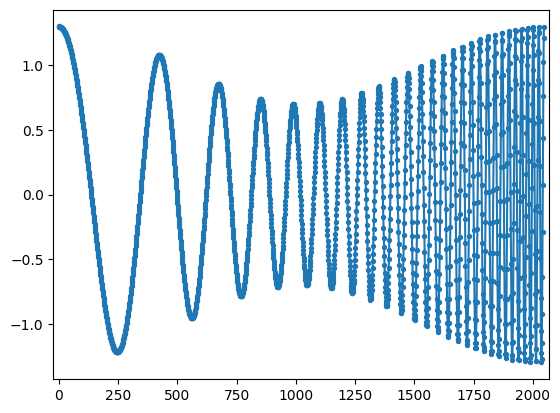

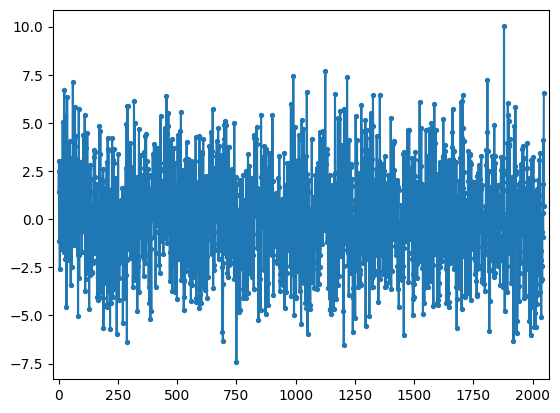

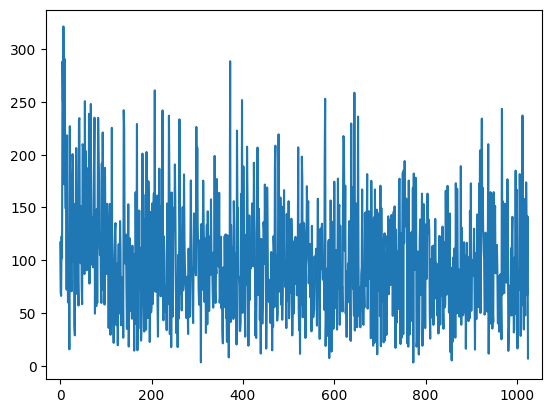

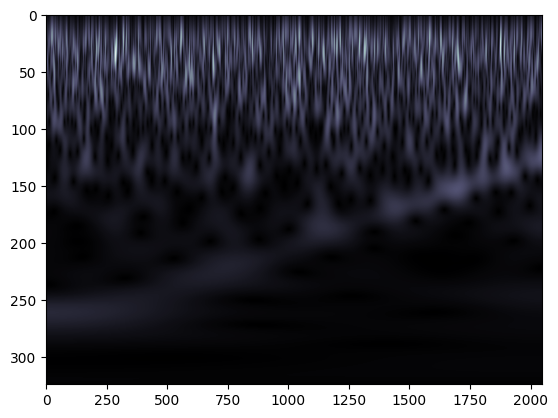

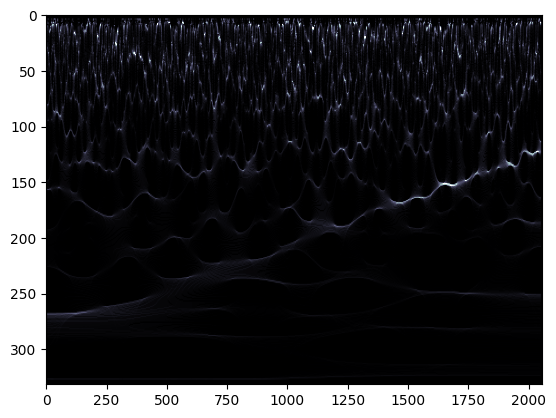

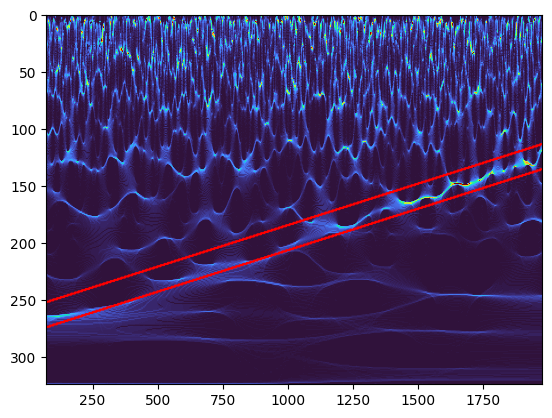

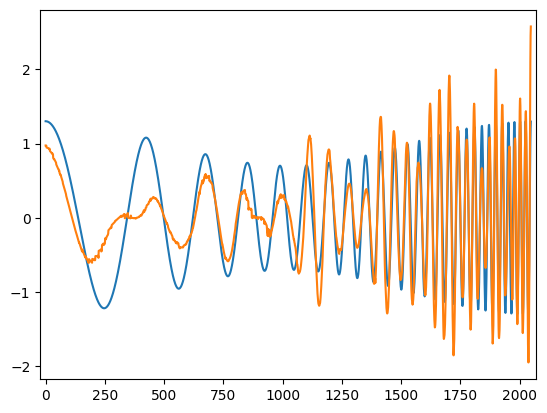

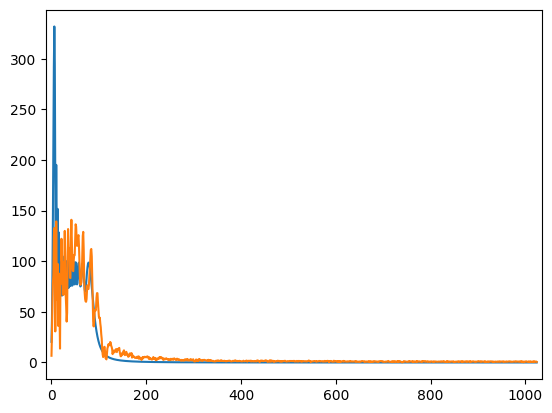

signal   MAD/RMS: 0.475716
spectrum MAD/RMS: 0.145670


In [24]:
# -*- coding: utf-8 -*-
if __name__ != '__main__':
    raise Exception("ran example file as non-main")

import numpy as np
from numpy.fft import rfft

from ssqueezepy import ssq_cwt, issq_cwt, cwt
from ssqueezepy.toolkit import lin_band, cos_f, mad_rms
from ssqueezepy.visuals import imshow, plot, scat

#%%###########################################################################
def echirp(N):
    t = np.linspace(0, 10, N, False)
    return np.cos(2 * np.pi * np.exp(t / 3)), t

#%%## Configure signal #######################################################
N = 2048
noise_var = 6  # noise variance; compare error against = 12

x, ts = echirp(N)
x *= (1 + .3 * cos_f([1], N))  # amplitude modulation
xo = x.copy()
np.random.seed(4)
x += np.sqrt(noise_var) * np.random.randn(len(x))

#### Show signal & its global spectrum #######################################
axf = np.abs(rfft(x))

plot(xo); scat(xo, s=8, show=1)
plot(x);  scat(x,  s=8, show=1)
plot(axf, show=1)

#%%# Synchrosqueeze ##########################################################
kw = dict(wavelet=('morlet', {'mu': 4.5}), nv=32, scales='log')
Tx, *_ = ssq_cwt(x, t=ts, **kw)
Wx, *_ = cwt(x, t=ts, **kw)

#%%# Visualize ###############################################################
pkw = dict(abs=1, cmap='bone')
_Tx = np.pad(Tx, [[4, 4]])  # improve display of top- & bottom-most freqs
imshow(Wx, **pkw)
imshow(_Tx, norm=(0, 4e-1), **pkw)

#%%# Estimate inversion ridge ###############################################
bw, slope, offset = .035, -.46, -1.8
Cs, freqband = lin_band(Tx, slope, offset, bw, norm=(0, 4e-1))

#%%###########################################################################
xrec = issq_cwt(Tx, kw['wavelet'], Cs, freqband)[0]
plot(xo)
plot(xrec, show=1)

axof   = np.abs(rfft(xo))
axrecf = np.abs(rfft(xrec))
plot(axof)
plot(axrecf, show=1)

print("signal   MAD/RMS: %.6f" % mad_rms(xo, xrec))
print("spectrum MAD/RMS: %.6f" % mad_rms(axof, axrecf))


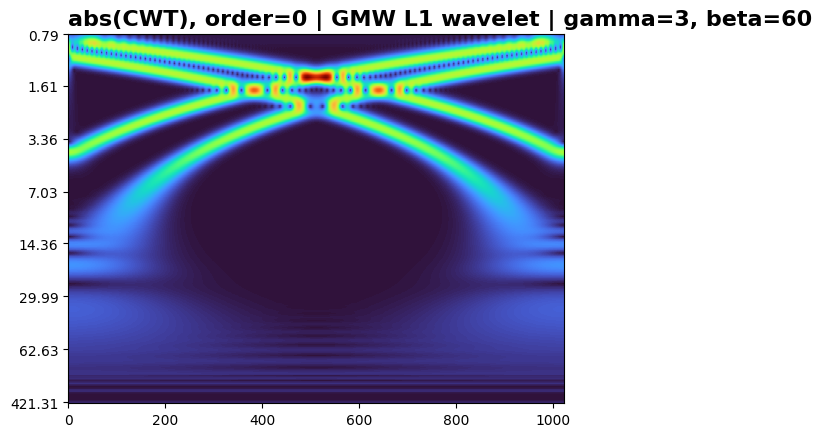

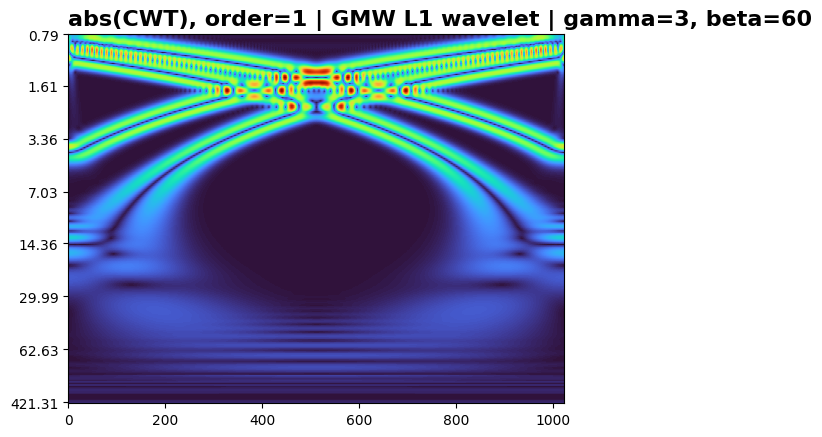

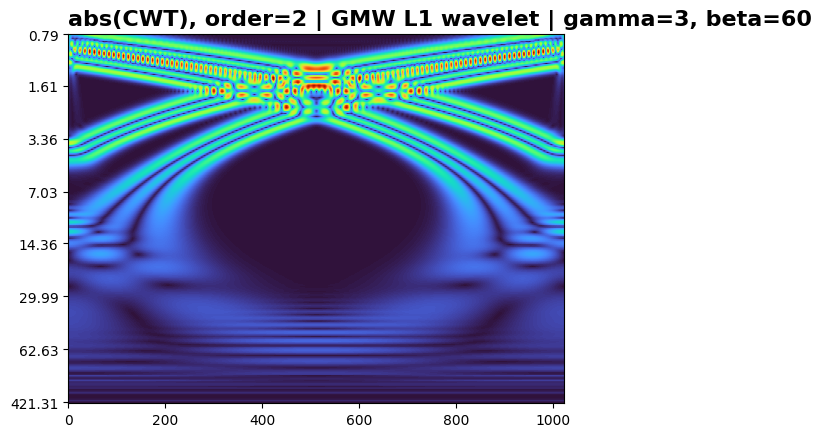

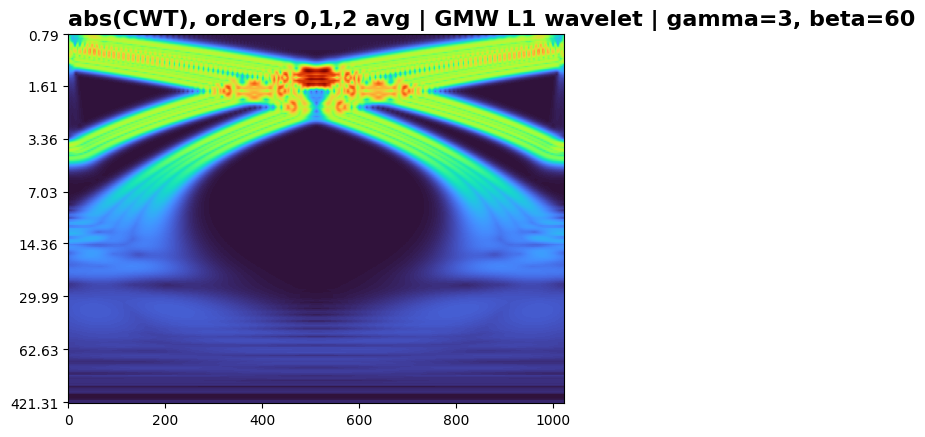

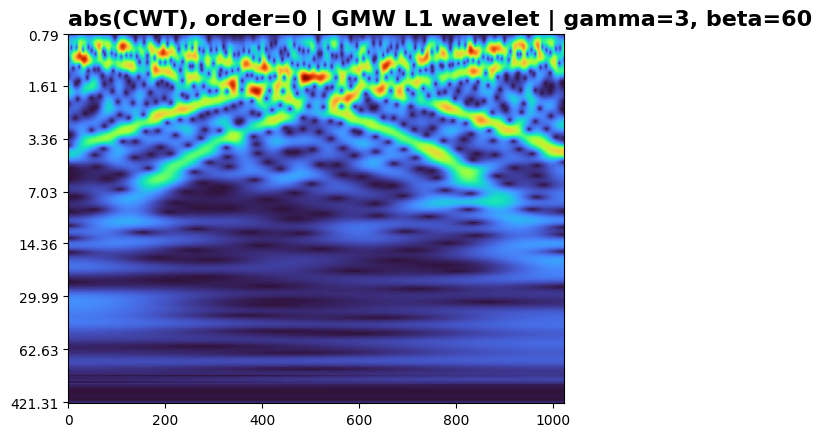

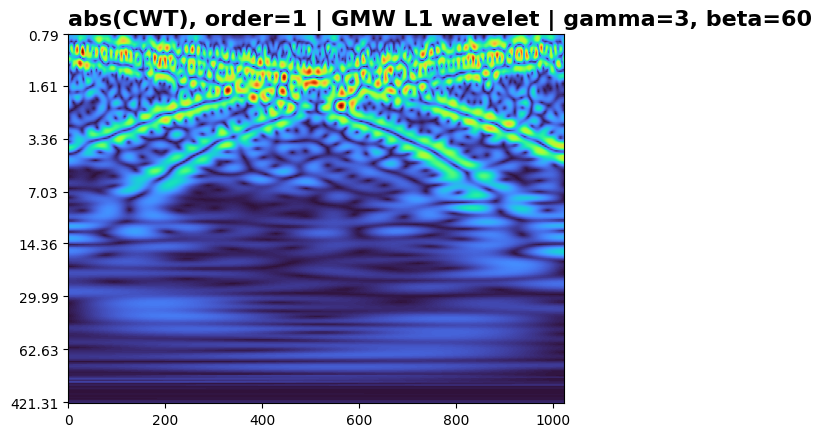

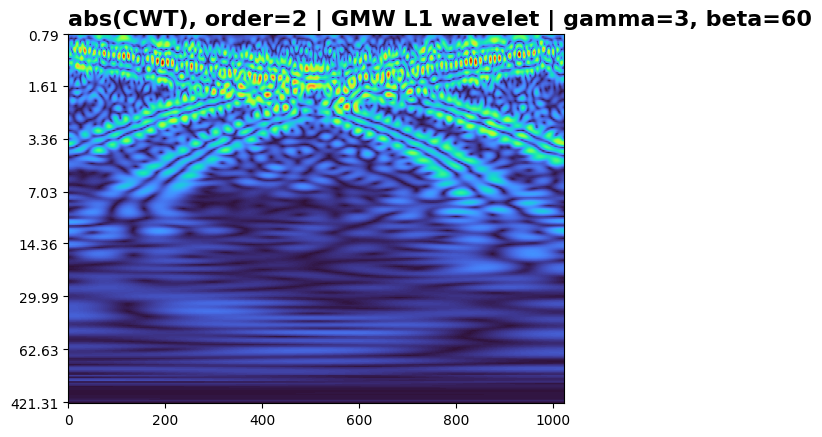

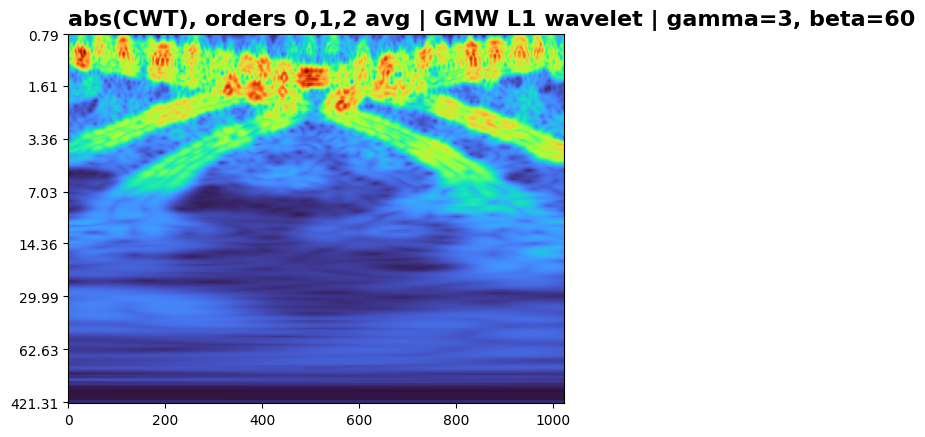

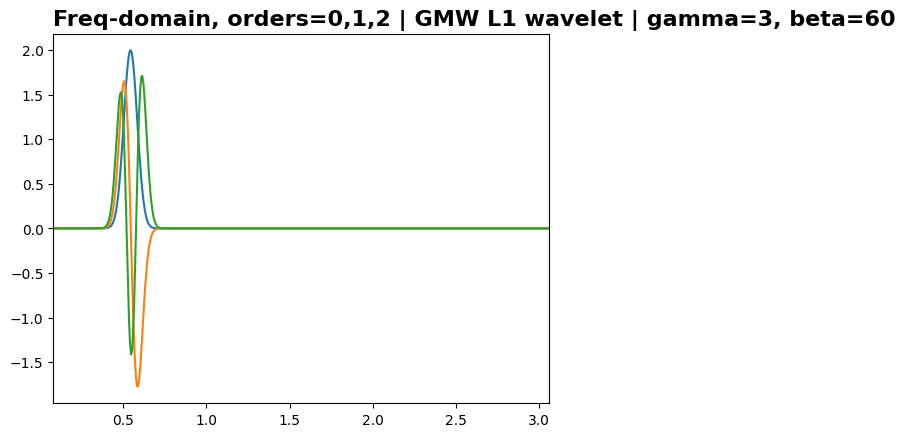

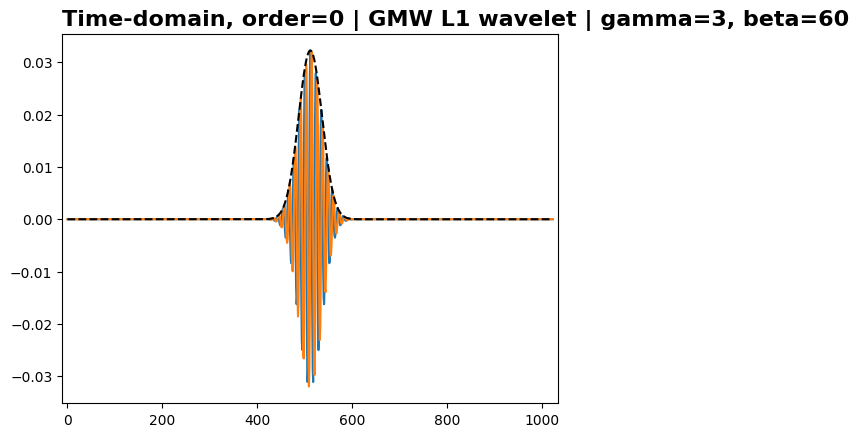

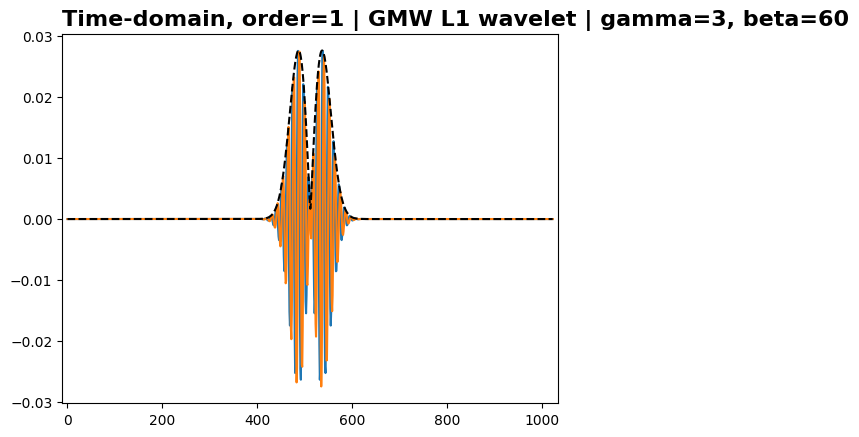

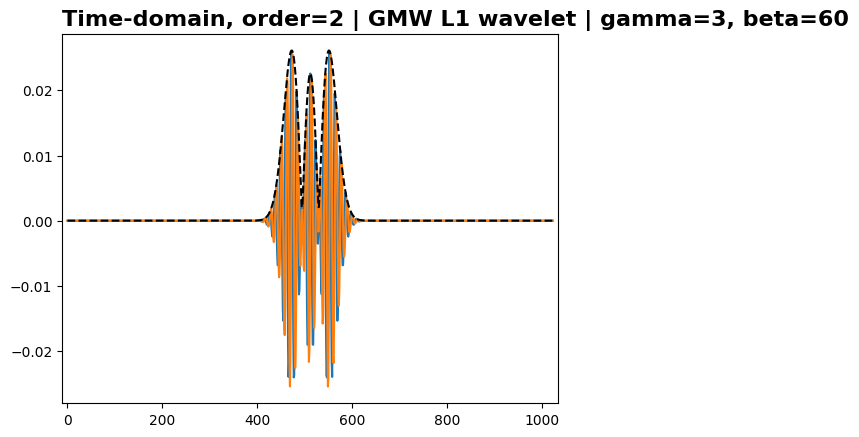

In [26]:
# -*- coding: utf-8 -*-
"""Show CWT with higher-order Generalized Morse Wavelets on parallel reflect-added
linear chirps, with and without noise, and show GMW waveforms.
"""
if __name__ != '__main__':
    raise Exception("ran example file as non-main")

import numpy as np
from ssqueezepy import cwt, TestSignals
from ssqueezepy.visuals import viz_cwt_higher_order, viz_gmw_orders

#%%# CWT with higher-order GMWs #############################################
N = 1024
order = 2

tsigs = TestSignals()
x, t = tsigs.par_lchirp(N=N)
x += x[::-1]

for noise in (False, True):
    if noise:
        x += np.random.randn(len(x))
    Wx_k, scales = cwt(x, 'gmw', order=range(order + 1), average=False)

    viz_cwt_higher_order(Wx_k, scales, 'gmw')
    print("=" * 80)

#%%# Higher-order GMWs #######################################################
gamma, beta, norm = 3, 60, 'bandpass'
n_orders = 3
scale = 5

viz_gmw_orders(N, n_orders, scale, gamma, beta, norm)


0.00089307677 0.22748165 448.1102


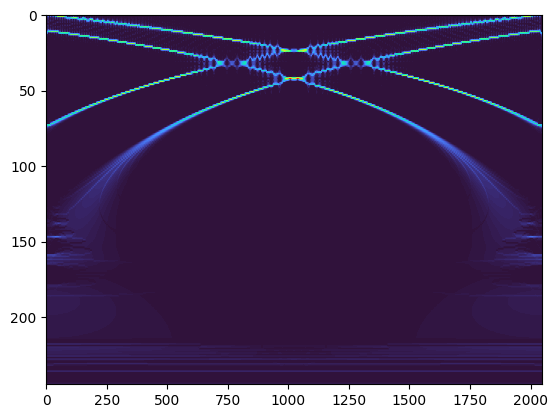

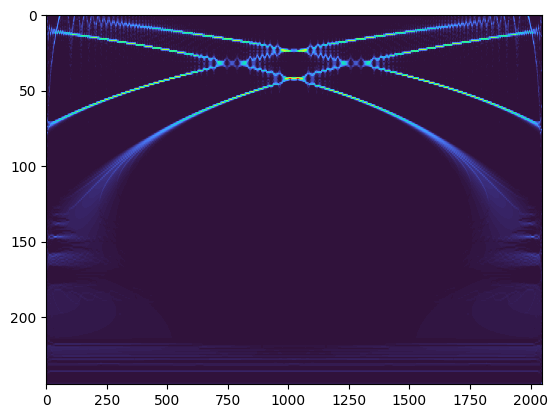

In [32]:
# -*- coding: utf-8 -*-
"""Experimental feature example."""
if __name__ != '__main__':
    raise Exception("ran example file as non-main")

import numpy as np
from ssqueezepy import TestSignals, ssq_cwt, Wavelet
from ssqueezepy.visuals import imshow
from ssqueezepy.experimental import phase_ssqueeze

#%%
x = TestSignals(N=2048).par_lchirp()[0]
x += x[::-1]
wavelet = Wavelet()

Tx0, Wx, _, scales, *_ = ssq_cwt(x, wavelet, get_dWx=1)
Tx1, *_ = phase_ssqueeze(Wx, wavelet=wavelet, scales=scales, flipud=1)

adiff = np.abs(Tx0 - Tx1)
print(adiff.mean(), adiff.max(), adiff.sum())
#%%
# main difference near boundaries; see `help(trigdiff)` w/ `rpadded=False`
imshow(Tx0, abs=1)

imshow(Tx1, abs=1)



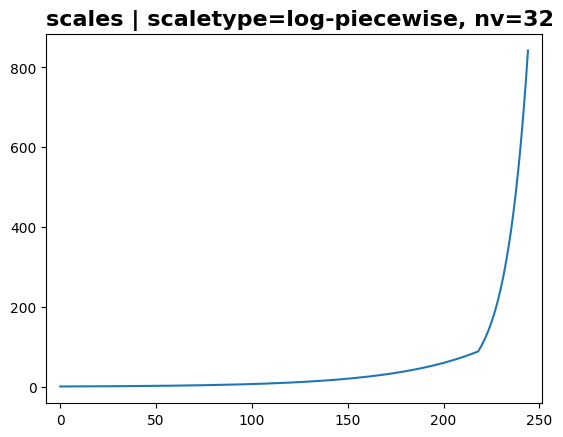

n_scales=245, max(scales)=842.6, logscale_transition_idx=219


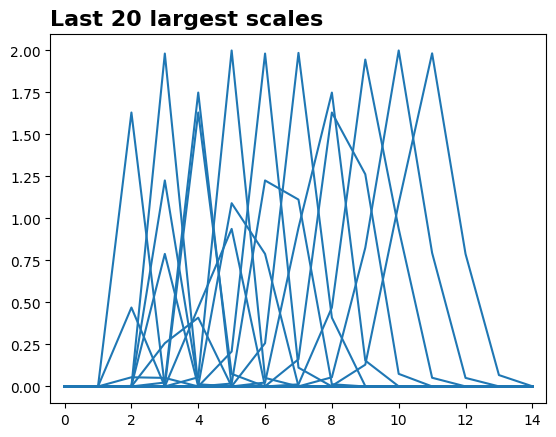

findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.


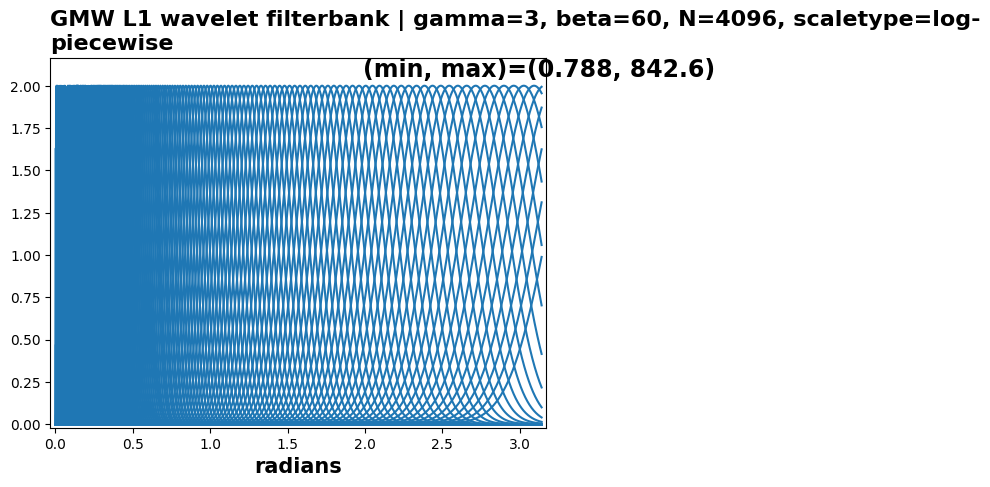

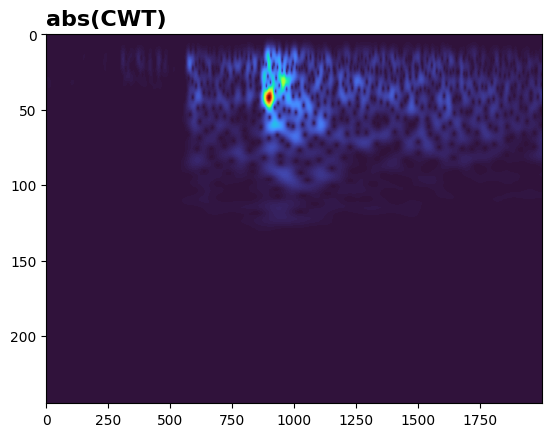

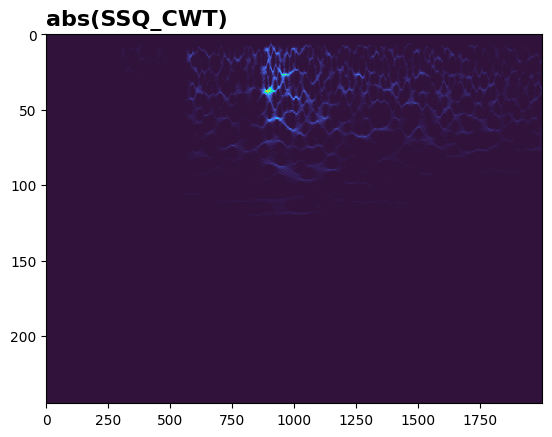

In [34]:
# -*- coding: utf-8 -*-
"""Shows methods to use for CWT scales selection; also see their docstrings."""
if __name__ != '__main__':
    raise Exception("ran example file as non-main")

import numpy as np
from ssqueezepy import ssq_cwt, Wavelet
from ssqueezepy.visuals import imshow, plot
from ssqueezepy.utils import cwt_scalebounds, make_scales, p2up
from ssqueezepy.utils import logscale_transition_idx

#%%# Helper visual method ####################################################
def viz(wavelet, scales, scaletype, show_last, nv):
    plot(scales, show=1, title="scales | scaletype=%s, nv=%s" % (scaletype, nv))
    if scaletype == 'log-piecewise':
        extra = ", logscale_transition_idx=%s" % logscale_transition_idx(scales)
    else:
        extra = ""
    print("n_scales={}, max(scales)={:.1f}{}".format(
        len(scales), scales.max(), extra))

    psih = wavelet(scale=scales)
    last_psihs = psih[-show_last:]

    # find xmax of plot
    least_large = last_psihs[0]
    mx_idx = np.argmax(least_large)
    last_nonzero_idx = np.where(least_large[mx_idx:] < least_large.max()*.1)[0][0]
    last_nonzero_idx += mx_idx + 2

    plot(last_psihs.T[:last_nonzero_idx], color='tab:blue', show=1,
         title="Last %s largest scales" % show_last)

#%%# EDIT HERE ###############################################################
# signal length
# N = 2048
# # your signal here
# t = np.linspace(0, 1, N, endpoint=False)
# x = np.cos(2*np.pi * 16 * t) + np.sin(2*np.pi * 64 * t)

N = (t2-t1) * fq
 
fs=100 #采样频率
t1 , t2 = 20,40
data2 = data_raw_d[: , int(fq * t1) : int(fq * t2) ]
x=data2[800]  #一维数据
t = np.linspace(0, t2-t1 , num=(t2-t1) * fq)


# choose wavelet
wavelet = 'gmw'
# choose padding scheme for CWT (doesn't affect scales selection)
padtype = 'reflect'

# one of: 'log', 'log-piecewise', 'linear'
# 'log-piecewise' lowers low-frequency redundancy; see
# https://github.com/OverLordGoldDragon/ssqueezepy/issues/29#issuecomment-778526900
scaletype = 'log-piecewise'
# one of: 'minimal', 'maximal', 'naive' (not recommended)
preset = 'maximal'
# number of voices (wavelets per octave); more = more scales
nv = 32
# downsampling factor for higher scales (used only if `scaletype='log-piecewise'`)
downsample = 4
# show this many of lowest-frequency wavelets
show_last = 20

#%%## Make scales ############################################################
# `cwt` uses `p2up`'d N internally
M = p2up(N)[0]
wavelet = Wavelet(wavelet, N=M)

min_scale, max_scale = cwt_scalebounds(wavelet, N=len(x), preset=preset)
scales = make_scales(N, min_scale, max_scale, nv=nv, scaletype=scaletype,
                     wavelet=wavelet, downsample=downsample)

#%%# Visualize scales ########################################################
viz(wavelet, scales, scaletype, show_last, nv)
wavelet.viz('filterbank', scales=scales)

#%%# Show applied ############################################################
Tx, Wx, ssq_freqs, scales, *_ = ssq_cwt(x, wavelet, scales=scales,
                                        padtype=padtype)
imshow(Wx, abs=1, title="abs(CWT)")
imshow(Tx, abs=1, title="abs(SSQ_CWT)")